# Novelist


Features to support:
- "Initial flow": summary, details, style
    - If no chapters already, accept
- "Next chapter" - with optional instructions
- "Rewrite chapter" - with optional instructions
- Rewind to chapter X


I think it makes sense to implement the main `State` as a tree then. Whenever you start a new "version" of a chapter, you could give it a name (almost git-like...)

Think there's probably a better way around this purely using the graph state, but was hard to figure out...

State and utilites

In [2]:
import hashlib
from typing import Annotated, Any, Dict, List, Literal, Optional
from typing_extensions import TypedDict


def add_chapter(left: Optional[list | Any], right: Optional[list | Any]) -> list:
    if not isinstance(left, list):
        left = [left]
    if right is None:
        return left
    if not isinstance(right, list):
        right = [right]
    return left + right


def update_dict(left: Optional[dict], right: Optional[dict]) -> dict:
    if left is None:
        left = {}
    if right is None:
        right = {}
    left.update(right)
    return left


class Commit(TypedDict):
    content: str
    instructions: Optional[str]
    parent: Optional[str]


class Branch(TypedDict):
    name: str
    commit: str


class InitializeAction(TypedDict):
    action: Literal["initialize"]
    summary: str
    details: str
    style: str


class NextAction(TypedDict):  # Write a new commit on the current branch
    action: Literal["next"]
    instructions: Optional[str]


class RewriteAction(TypedDict):  # overwrite a commit
    action: Literal["rewrite"]
    instructions: str


class RewindAction(TypedDict):  # Checkout a previous commit
    action: Literal["rewind"]
    commit: str


class BranchAction(TypedDict):  # Create a new branch at the current commit
    action: Literal["branch"]
    branch: str


class Command(TypedDict):
    action: InitializeAction | NextAction | RewriteAction | RewindAction | BranchAction


class NovelistState(TypedDict):
    # User's initial inputs (could be updated later)
    summary: str
    details: str
    style: str
    # New command each user invocation:
    command: Optional[Command]
    # Internally managed state:
    commits: Annotated[Dict[str, Commit], update_dict]
    branches: Annotated[Dict[str, Branch], update_dict]
    head: Annotated[
        str,
        lambda left, right: (
            right if right is not None else (left if left is not None else "main")
        ),
    ]


def generate_commit_id(commit: Commit) -> str:
    # Generate a unique commit ID based on the commit content and parent
    commit_str = f"{commit['content']}{commit['parent']}"
    commit_id = hashlib.sha256(commit_str.encode()).hexdigest()
    return commit_id


def format_commit(
    parent: Optional[str], content: str, instructions: Optional[str] = None
):
    new_commit = {"content": content, "instructions": instructions, "parent": parent}
    commit_id = generate_commit_id(new_commit)
    return {"commit": new_commit, "commit_id": commit_id}


def get_commit_history(state: NovelistState, n: Optional[int] = None):
    if state["head"] in state["branches"]:
        commit_id = state["branches"][state["head"]]["commit"]
    else:
        # Assume it's a raw commit id
        commit_id = state["head"]
    history = []
    while commit_id is not None:
        commit = state["commits"][commit_id]
        history.append(commit)
        commit_id = commit["parent"]
        if n is not None and len(history) >= n:
            break
    return history[::-1]

In [3]:
from langchain_anthropic import ChatAnthropic
from langchain import hub
from langchain_core.pydantic_v1 import BaseModel, Field
from langchain_core.output_parsers.openai_tools import JsonOutputToolsParser
from langchain_core.output_parsers import StrOutputParser


prompt = hub.pull("wfh/lovecraft")

llm = ChatAnthropic(model="claude-3-haiku-20240307", max_tokens_to_sample=4000)

runnable = prompt | llm | StrOutputParser()

In [17]:
from langchain_core.runnables import RunnableConfig

def parse(txt: str):
    if "<content>" in txt:
        txt = txt.split("<content>")[1]
    if "</content>" in txt:
        txt = txt.split("</content>")[0]
    return txt
async def writer(state: NovelistState, config: RunnableConfig):
    action = state["command"]["action"]
    if action["action"] not in ["next", "rewrite"]:
        raise ValueError(f"Invalid action: {action['action']}")
    action_str = action["action"]
    n_chapters = config["configurable"].get("n") or 10
    history = get_commit_history(state)
    history = [h for h in history if h.get("content")]
    contents = [commit["content"] for commit in history]
    chapters_str = "\n\n".join(
        [f"Chapter {i+1}\n\n{content}" for i, content in enumerate(contents)]
    ).strip()
    if chapters_str:
        user_message = f"Here's what we have so far:\n\n<Progress>\n{chapters_str}</Progress>\nInstructions: "
    else:
        user_message = ""
    if action_str == "next":
        user_message += "Generate the next chapter."
    else:
        user_message += "Rewrite the most recent chapter."
    user_instructions = (action.get("instructions") or "").strip() or None
    if user_instructions:
        user_message += " " + user_instructions 
    generated = []
    async for tok in runnable.astream({**state, "messages": [("user", user_message)]}):
        print(tok, end="")
        generated.append(tok)

    chapter_str = parse("".join(generated))
    if action_str == "next":
        # Create a new commit on the current branch
        current_branch = state["branches"][state["head"]]
        commit_info = format_commit(
            current_branch["commit"],
            chapter_str,
            user_instructions,
        )
        current_branch["commit"] = commit_info["commit_id"]
        return {
            "commits": {commit_info["commit_id"]: commit_info["commit"]},
            "branches": {state["head"]: current_branch},
        }
    else:
        # Update the current commit with the new content
        commit_id = state["branches"][state["head"]]["commit"]
        state["commits"][commit_id]["content"] = chapter_str
        state["commits"][commit_id]["instructions"] = user_instructions
        return {"commits": state["commits"]}


def create_branch(state: NovelistState, branch_name: str):
    if state["branches"] and branch_name in state["branches"]:
        raise ValueError(f"Branch {branch_name} already exists")
    current_branch = (state.get("branches") or {}).get(state.get("head"))
    if current_branch:
        current_commit = current_branch["commit"]
    else:
        # Assume head is a commit ID
        current_commit = state.get("head")

    return {
        branch_name: {
            "name": branch_name,
            "commit": current_commit,
        }
    }


async def manage_history(state: NovelistState, config: RunnableConfig):
    action = state["command"]["action"]
    if action["action"] == "initialize":
        # Initialize the state with the user's inputs
        initial_commit = format_commit(None, "")
        return {
            "head": "main",
            "branches": {
                "main": {"name": "main", "commit": initial_commit["commit_id"]}
            },
            "commits": {initial_commit["commit_id"]: initial_commit["commit"]},
            "summary": action["summary"],
            "details": action["details"],
            "style": action["style"],
        }
    if not state["branches"]:
        raise ValueError("Novelist graph not yet initialized")
    if action["action"] == "branch":
        return {"branches": create_branch(state, action["branch"]), "head": action["branch"]}
    if action["action"] == "rewind":
        # Checkout a previous commit
        commit_id = action["commit"]
        # If the commit is not in the commit history, raise an error
        if commit_id not in state["commits"]:
            raise ValueError(f"Commit {commit_id} not found")
        return {
            "head": commit_id,
            "branch": None,
        }

    # next | rewrite
    return {}


In [18]:
from langgraph.graph import StateGraph
from langgraph.checkpoint.aiosqlite import AsyncSqliteSaver


builder = StateGraph(NovelistState)

builder.add_node("manage_history", manage_history)
builder.add_node("writer", writer)
builder.set_entry_point("manage_history")


def route_to_writer(state: NovelistState) -> Literal["writer", "__end__"]:
    action = state["command"]["action"]
    if action["action"] in ["next", "rewrite"]:
        return "writer"
    return "__end__"


builder.add_conditional_edges("manage_history", route_to_writer)
builder.set_finish_point("writer")
memory = AsyncSqliteSaver.from_conn_string(":memory:")
graph = builder.compile(checkpointer=memory)

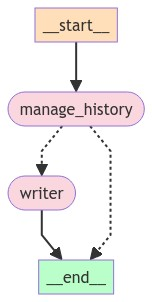

In [19]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph(xray=True).draw_mermaid_png()))
except:
    # This requires some extra dependencies and is optional
    pass

In [20]:
async def get_current_story(graph, config):
    snapshot = await graph.aget_state(config)
    return get_commit_history(snapshot.values)
    

In [21]:
config = {
    "configurable": {
        "n": 10,
        "thread_id": "1234",
    }
}

init_result = await graph.ainvoke(
    {
        "command": {
            "action": {
                "action": "initialize",
                "summary": "Years after the cultural revolution, the daughter of a blacklisted physicist makes first contact with alien life.",
                "style": "Lovecraftian horror",
                "details": "N/A",
            }
        },
    },
    config,
)

results = await graph.ainvoke(
    {
        "command": {
            "action": {
                "action": "next",
                "instructions": "Write a chapter about a haunted house",
            }
        },
    },
    config,
)

<Chapter>

The old Dunwitch Manor loomed before them, an ominous silhouette against the darkening sky. Its once-grand façade was now crumbling, ivy snaking up the sides like grasping fingers. A heavy air of dread and abandonment hung over the property, making the hair on the back of Amelia's neck stand on end.

Amelia gripped the steering wheel tightly, her knuckles turning white. "Are you sure about this, Dad? This place gives me the creeps."

Her father, Dr. Nathaniel Westing, gazed up at the manor, a determined glint in his eyes. "I have to, Amelia. This could be the key to making first contact. I can feel it."

Amelia sighed, knowing there was no changing her father's mind once it was made up. She reluctantly followed him up the overgrown driveway towards the imposing front doors. 

As they approached, an eerie howl echoed through the still air, causing Amelia to jump. "What was that?" she whispered, her voice shaking.

"Just the wind," her father replied, though he too seemed unse

In [22]:
results = await graph.ainvoke(
    {
        "command": {
            "action": {
                "action": "next",
                "instructions": "Now have the protagonist make first contact with aliens by sending an EM beam off the sun",
            }
        },
    },
    config,
)

<Chapter>

The air was thick with tension as Amelia and her father climbed the grand staircase, their footsteps echoing ominously. Amelia's heart pounded in her chest, her apprehension growing with every step. 

As they reached the landing, a deafening crash reverberated from somewhere deeper within the manor, making them both jump. Amelia clutched her father's arm, her fingers digging into the fabric of his sleeve.

"What was that?" she whispered, her voice trembling.

Dr. Westing's brow furrowed, his gaze fixed on the darkened hallway ahead. "I don't know, but we have to find out."

Amelia's protests caught in her throat as her father forged ahead, his determination unwavering. With a resigned sigh, she followed close behind, trying to ignore the unsettling feeling that they were being watched.

The hallway was shrouded in shadow, the only light filtering in through the grimy windows. Amelia strained her eyes, trying to make out the details of their surroundings. Strange symbols were

In [23]:
await get_current_story(graph, config)

[{'content': '', 'instructions': None, 'parent': None},
 {'content': '<Chapter>\n\nThe old Dunwitch Manor loomed before them, an ominous silhouette against the darkening sky. Its once-grand façade was now crumbling, ivy snaking up the sides like grasping fingers. A heavy air of dread and abandonment hung over the property, making the hair on the back of Amelia\'s neck stand on end.\n\nAmelia gripped the steering wheel tightly, her knuckles turning white. "Are you sure about this, Dad? This place gives me the creeps."\n\nHer father, Dr. Nathaniel Westing, gazed up at the manor, a determined glint in his eyes. "I have to, Amelia. This could be the key to making first contact. I can feel it."\n\nAmelia sighed, knowing there was no changing her father\'s mind once it was made up. She reluctantly followed him up the overgrown driveway towards the imposing front doors. \n\nAs they approached, an eerie howl echoed through the still air, causing Amelia to jump. "What was that?" she whispered, 

In [24]:
results = await graph.ainvoke(
    {
        "command": {
            "action": {
                "action": "rewrite",
                "instructions": "not sufficiently on theme",
            }
        },
    },
    config,
)

<Chapter>
The air was thick with tension as Amelia and her father climbed the grand staircase, their footsteps echoing ominously. Amelia's heart pounded in her chest, her apprehension growing with every step. 

As they reached the landing, a deafening crash reverberated from somewhere deeper within the manor, making them both jump. Amelia clutched her father's arm, her fingers digging into the fabric of his sleeve.

"What was that?" she whispered, her voice trembling.

Dr. Westing's brow furrowed, his gaze fixed on the darkened hallway ahead. "Something is not right here," he murmured, his voice low and grave. "We need to be cautious."

Amelia's protests caught in her throat as her father forged ahead, his determination unwavering. With a resigned sigh, she followed close behind, trying to ignore the unsettling feeling that they were being watched.

The air seemed to hum with a strange, unseen energy as they ventured deeper into the manor. Amelia couldn't help but notice the strange sy

In [25]:
vals = (await graph.aget_state(config)).values
commits= list(vals['commits'])
commits

['7bb28bc35c73010aee5c15dc834c33c8b21e8e114f0b3371fb82decefe339b45',
 '9aef3f02fe7b64b213eea392412660cb63b611d5b03a98d4437b6b04b6cabbb9',
 'dc937b59892604f5a86ac96936cd7ff09e25f18ae6b758e8014a24c7fa039e91']

In [26]:
results = await graph.ainvoke(
    {
        "command": {
            "action": {
                "action": "rewind",
                "commit": commits[0],
            }
        },
    },
    config,
)

In [27]:
results = await graph.ainvoke(
    {
        "command": {
            "action": {
                "action": "branch",
                "branch": "take-2",
            }
        },
    },
    config,
)

In [28]:
vals = (await graph.aget_state(config)).values
vals['head']

'take-2'

Overwrite the existing story

In [29]:
results = await graph.ainvoke(
    {
        "command": {
            "action": {
                "action": "next",
                "instructions": "Write a chapter about a mysterious series of suicides amongst top scientists. Make it sci-fi though. ",
            }
        },
    },
    config,
)

Here is the next chapter:

<Chapter>
The news hit like a shockwave through the scientific community. One by one, brilliant minds were taking their own lives - prominent physicists, astrophysicists, computer scientists, all seemingly driven to self-destruction. 

Amelia watched the reports with a growing sense of dread, her mind racing. She couldn't escape the feeling that these tragic events were somehow connected to the ominous discovery in Dunwich Manor. 

"There has to be a pattern," she murmured, her brow furrowed in concentration as she pored over the news articles. "Something is driving these people to do this."

Her father, Dr. Nathaniel Westing, sat silently beside her, his expression unreadable. Amelia knew that the experience in the manor had shaken him, though he refused to speak of it. 

"Dad, you have to tell me what happened that day," she pleaded. "Whatever that thing was, it's clearly connected to these suicides. We need to understand what's going on."

Dr. Westing sigh

In [31]:
await graph.ainvoke(
    {
        "command": {
            "action": {
                "action": "next",
                "instructions": "Write a chapter about a haunted house",
            }
        },
    },
    config,
)

Here is the next chapter:

<Chapter>
The old Dunwich Manor loomed before them, its towering spires casting long shadows across the overgrown grounds. Amelia felt a chill run down her spine as she stared up at the crumbling facade, the memories of their last visit still fresh in her mind.

"Are you sure about this, Dad?" she asked, her voice laced with trepidation. "After what happened last time, I don't know if we should be going back there."

Dr. Westing's expression was resolute, his eyes narrowed with determination. "We have to, Amelia. Whatever is causing these suicides, I'm convinced it's tied to that place. We need to find out what's going on, no matter the risk."

Amelia sighed, knowing there was no dissuading her father once his mind was made up. Steeling her nerves, she followed him up the overgrown path towards the imposing front doors.

As they approached, Amelia couldn't shake the feeling that they were being watched. The air seemed to hum with an unseen energy, the shadows

{'summary': 'Years after the cultural revolution, the daughter of a blacklisted physicist makes first contact with alien life.',
 'details': 'N/A',
 'style': 'Lovecraftian horror',
 'command': {'action': {'action': 'next',
   'instructions': 'Write a chapter about a haunted house'}},
 'commits': {'215f802dbe22092712da37c96a62e4379eb76c506e5bf7be1e822b9bb82764f5': {'content': 'Here is the next chapter:\n\n<Chapter>\nThe news hit like a shockwave through the scientific community. One by one, brilliant minds were taking their own lives - prominent physicists, astrophysicists, computer scientists, all seemingly driven to self-destruction. \n\nAmelia watched the reports with a growing sense of dread, her mind racing. She couldn\'t escape the feeling that these tragic events were somehow connected to the ominous discovery in Dunwich Manor. \n\n"There has to be a pattern," she murmured, her brow furrowed in concentration as she pored over the news articles. "Something is driving these people 

In [ ]:

for tok in runnable.stream(state):
    print(tok, end="")